<a href="https://colab.research.google.com/github/XinyaoTian/COMP5318_assignment2/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5318 Assignment 2
*Make sure you change the file name with your unikey*


# 1. Data set up


In [0]:
# Environment setup
# Import assignment-wide packages
import sklearn
import numpy as np
import os
import pandas as pd
np.random.seed(42)

from random import uniform
import math

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# import hierarchical clustering packages
from sklearn.cluster import AgglomerativeClustering

# import DBSCAN packages
from sklearn.cluster import DBSCAN

# import evaluation packages
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

## 1.1 Load Data

*Please upload both datasets (any file format is ok) to your google drive, and load the datasets through google drive file id in your code. If you want to use Jupyter, please submit all the dataset in an additional zip file.*



In [3]:
# Load TripAdviosr dataset from its original source
TA_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv", sep=',', encoding="utf-8")

# Have a brief view
TA_data.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [4]:
# Statistical Description
TA_data.describe()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,0.893194,1.352612,1.013306,0.532500,0.939735,1.842898,3.180939,2.835061,1.569439,2.799224
std,0.326912,0.478280,0.788607,0.279731,0.437430,0.539538,0.007824,0.137505,0.364629,0.321380
min,0.340000,0.000000,0.130000,0.150000,0.060000,0.140000,3.160000,2.420000,0.740000,2.140000
25%,0.670000,1.080000,0.270000,0.410000,0.640000,1.460000,3.180000,2.740000,1.310000,2.540000
50%,0.830000,1.280000,0.820000,0.500000,0.900000,1.800000,3.180000,2.820000,1.540000,2.780000
75%,1.020000,1.560000,1.572500,0.580000,1.200000,2.200000,3.180000,2.910000,1.760000,3.040000
max,3.220000,3.640000,3.620000,3.440000,3.300000,3.760000,3.210000,3.390000,3.170000,3.660000


In [5]:
# Load ICMLA papers dataset from its original source
ICMLA_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00434/ICMLA_2014.csv", sep=',', encoding="ISO-8859-1")

# Also have a brief look
ICMLA_data.head()

,paper_id,paper_title,author_keywords,abstract,session
0,1,Ensemble Statistical and Heuristic Models for ...,"statistical word alignment, ensemble learning,...",Statistical word alignment models need large a...,Ensemble Methods
1,2,Improving Spectral Learning by Using Multiple ...,"representation, spectral learning, discrete Fo...",Spectral learning algorithms learn an unknown ...,Ensemble Methods
2,3,Applying Swarm Ensemble Clustering Technique f...,"Software defect prediction, Particle swarm opt...",Number of defects remaining in a system provid...,Ensemble Methods
3,4,Reducing the Effects of Detrimental Instances,"filtering, label noise, instance weighting",Not all instances in a data set are equally be...,Ensemble Methods
4,5,Concept Drift Awareness in Twitter Streams,"Twitter, Adaptation models, Time-frequency ana...",Learning in non-stationary environments is not...,Ensemble Methods


## 1.2 Data Preprocessing (optional)

***You are required to show your data preprocessing methods for the two datasets (if necessary)***

*You can apply different data preprocessing techniques in different data and clustering models if you need.*


### Travel Review Dataset

In [6]:
# Brief review the dataset
TA_data.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [0]:
# It's obviously that 'User ID' is not meaningful when clustering
# So we delete that column
TA_data = TA_data.drop('User ID', 1)

In [8]:
TA_data.head()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [9]:
TA_data.dtypes

Category 1     float64
Category 2     float64
Category 3     float64
Category 4     float64
Category 5     float64
Category 6     float64
Category 7     float64
Category 8     float64
Category 9     float64
Category 10    float64
dtype: object

### ICMLA Datasets

In [0]:
# Please comment your code

### Classes and functions rebuild

We designed a new class of gridsearch in order to meet the requirements of our assignment.

The more concise and convenient the invocation, the more complicated the design behind it, and greater the effort as well.

 Just like the design of iPhone.

In [0]:
# K means clustering algorithm
class KMeansClustering():

  # initiate construction function
  def __init__(self, k_numbers=1, similarity='euclidean', convergence_threshold = 0.01):
    self.Data = None
    self.k = k_numbers
    self.similarity = similarity
    self.centroids = None
    self.DataDistributed = None
    self.convergence_threshold = convergence_threshold
    self.labels_ = None

    # sub-process
    self.centroids_iteration = list()
    self.DataDistributed_iteration = list()
    self.centroids_moving_distance = list()
  

  # initate k numbers of centroids
  def generate_initial_centroids(self):
    # automatically generate initial centroids
    i = 0
    centroids = list()
    while(i < self.k):
      centroid = dict()
      for column in self.Data.columns:
        # randomly generate a value in the range of column
        centroid[column] = float("{:.4f}".format(uniform(self.Data[column].min(0), self.Data[column].max(0))))
      centroids.append(centroid)
      i += 1
    # after generating centroids
    self.centroids = pd.DataFrame(centroids)
    return self.centroids


  # assign points to a cluster located by a centroid
  def assign_points(self):
    # create a list to store the closest distance
    distance_list = list()
    cluster_index = list()
    # iteration of rows(each point) in dataset
    for index_point, point in self.Data.iterrows():
      closest_distance = -1
      distributed_centroid = -1
      # for each point, calculate the distance from it to a centroid
      for index_centroid, centroid in self.centroids.iterrows():
        # ------ select distance type ------#
        # select distance type
        if self.similarity == "euclidean":
          distance = self.euclidean_distance(point, centroid)
        elif self.similarity == "manhattan":
          distance = self.manhattan_distance(point, centroid)
        elif self.similarity == "minkowski":
          distance = self.minkowski_distance(point, centroid)
        elif self.similarity == "cosine":
          distance = self.cosine_distance(point, centroid)
        else:
          # throw out a warning
          distance = -1
        # ------ -------------------- ------#
        # judge if new distance is closer than existing one
        if closest_distance == -1 or distance < closest_distance:
          # if it's true then update distance
          closest_distance = distance
          distributed_centroid = index_centroid
      # append distance to storeage list
      distance_list.append(closest_distance)
      cluster_index.append(distributed_centroid)
    # Add the cloest distance as a column to Dataframe
    # Using copy() to avoid build a pointer between Data and DataDistributed
    self.DataDistributed = self.Data.copy()
    self.DataDistributed['Distance'] = distance_list
    self.DataDistributed['Cluster_index'] = cluster_index
    return self.DataDistributed


  # generate empty centroid data structure
  def generate_empty_centroids(self):
    # automatically generate initial centroids
    i = 0
    centroids = list()
    while(i < self.k):
      centroid = dict()
      for column in self.Data.columns:
        # randomly generate a value in the range of column
        centroid[column] = float(0.0)
      centroids.append(centroid)
      i += 1
    return pd.DataFrame(centroids)
  

  # recalculate the centroid
  def recalculate_centroid(self):
    # recalculate centroids groupby previous clusters
    # avoid Cluster_index become a new index
    new_centroids = self.DataDistributed.groupby(['Cluster_index'], as_index=False).mean().round(4)
    # drop middle-process columns
    self.centroids = new_centroids.drop('Cluster_index', 1).drop('Distance', 1)
    return self.centroids
  

  # main process of the whole training
  def fit(self, Data):
    # save data to model
    self.Data = Data

    # randomly generate k centroids
    self.generate_initial_centroids()
    self.centroids_iteration.append(self.centroids.copy())
    
    convergence = False
    # iterate until meet convergence condition
    while convergence == False:
      # assign points to these centroids
      self.assign_points()
      self.DataDistributed_iteration.append(self.DataDistributed.copy())
      # take the previous centroids
      previous_centroids = self.centroids.copy()
      # recalculate the centroids
      self.recalculate_centroid()
      new_centroids = self.centroids.copy()
      self.centroids_iteration.append(self.centroids.copy())

      # judge if meeting convergence condition
      centroids_movements = dict()
      for index, centroid in self.centroids.iterrows():
        convergence = True
        # ------ select distance type ------#
        if self.similarity == "euclidean":
          centroid_movement = self.euclidean_distance(previous_centroids.iloc[index], new_centroids.iloc[index])
        elif self.similarity == "manhattan":
          centroid_movement = self.manhattan_distance(previous_centroids.iloc[index], new_centroids.iloc[index])
        elif self.similarity == "minkowski":
          centroid_movement = self.minkowski_distance(previous_centroids.iloc[index], new_centroids.iloc[index])
        elif self.similarity == "cosine":
          centroid_movement = self.cosine_distance(previous_centroids.iloc[index], new_centroids.iloc[index])
        # ------ -------------------- ------#
        centroids_movements[index] = centroid_movement
        if centroid_movement >= self.convergence_threshold:
          convergence = False
      # record movement
      self.centroids_moving_distance.append(centroids_movements)
    self.labels_ = self.DataDistributed['Cluster_index'].to_numpy()
    

  # euclidean distance
  def euclidean_distance(self, pointA, pointB):
    sum_of_square = 0.0
    for column in self.Data.columns:
      sum_of_square += (pointA[column] - pointB[column])**2
    euclidean_distance = math.sqrt(sum_of_square)
    return float("{:.4f}".format(euclidean_distance))


  # manhattan distance
  def manhattan_distance(self, pointA, pointB):
    sum_of_abs = 0.0
    for column in self.Data.columns:
      sum_of_abs += abs(pointA[column] - pointB[column])
    manhattan_distance = sum_of_abs
    return float("{:.4f}".format(manhattan_distance))


  # Minkowski distance
  def minkowski_distance(self, pointA, pointB):
    # get degree of features
    degree = len(self.Data.columns)
    sum_of_poly_item = 0.0
    for column in self.Data.columns:
      sum_of_poly_item += pow(float("{:.4f}".format(pointA[column] - pointB[column])), degree)
    minkowski_distance = pow(sum_of_poly_item, 1/degree)
    return float("{:.4f}".format(minkowski_distance))
  

  # Cosine distance
  def cosine_distance(self, pointA, pointB):
    sum_of_dot_product = 0.0
    sum_of_square_pointA = 0.0
    sum_of_square_pointB = 0.0
    for column in self.Data.columns:
      sum_of_dot_product += pointA[column] * pointB[column]
      sum_of_square_pointA += pow(pointA[column], 2)
      sum_of_square_pointB += pow(pointB[column], 2)
    norm_of_pointA = math.sqrt(sum_of_square_pointA)
    norm_of_pointB = math.sqrt(sum_of_square_pointB)
    cosine_distance = sum_of_dot_product / (norm_of_pointA * norm_of_pointB)
    return float("{:.4f}".format(cosine_distance))

In [0]:
# write a new gridsearch class to handle our problem
class GridSearch():

  # class initiate
  def __init__(self, cluster_type, param_grid, score_type):
    self.Data = None
    self.param_grid = param_grid
    self.score_list = list()
    self.cluster_type = cluster_type
    self.score_type = score_type

  # run all combinations of parameters
  def fit(self, Data):
    # load data
    self.Data = Data
    if self.cluster_type == 'AgglomerativeClustering':
      self.__agglomerative_clustering()
    elif self.cluster_type == 'DBSCAN':
      self.__dbscan_clustering()
    elif self.cluster_type == 'KMeansClustering':
      self.__kmeans_clustering()
    # return the result list
    return "Grid Search Completed. Plase use get_results() to get best param combination."


  # KmeansClustering
  def __kmeans_clustering(self):
    # use all combinations of parameters to cluster
    for k in self.param_grid['k_numbers']:
      for similarity in self.param_grid['similarity']:
        score_dict = dict()
        # create new model using different params and evaluate through silouette score
        kmeans_model = KMeansClustering(k_numbers=k, similarity=similarity, convergence_threshold=0.01)
        kmeans_model.fit(self.Data)
        labels = kmeans_model.labels_
        # select different evaluation type
        if self.score_type == 'silhouette_score':
          # affinity of silhouette score should be consistent with similarity
          score = silhouette_score(self.Data, labels, metric=similarity)
        elif self.score_type == 'calinski_harabasz_score':
          score = calinski_harabasz_score(self.Data, labels=labels)
        elif self.score_type == 'davies_bouldin_score':
          score = davies_bouldin_score(self.Data, labels=labels)
        # save result to score_dict
        score_dict['k_numbers'] = k
        score_dict['similarity'] = similarity
        score_dict['score_type'] = self.score_type
        score_dict['score'] = score
        self.score_list.append(score_dict)
    # sorting the list by evaluation result
    self.score_list.sort(reverse=True, key=self.__sort_metric)

  
  # DBSCAN
  def __dbscan_clustering(self):
    # use all combinations of parameters to cluster
    for eps in self.param_grid['eps']:
      for min_samples in self.param_grid['min_samples']:
        for metric in self.param_grid['metric']:
          score_dict = dict()
          # create new model using different params and evaluate through silouette score
          dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
          dbscan_model.fit(self.Data)
          labels = dbscan_model.labels_
          # select different evaluation type
          if self.score_type == 'silhouette_score':
            # affinity of silhouette score should be consistent with similarity
            score = silhouette_score(self.Data, labels, metric=metric)
          elif self.score_type == 'calinski_harabasz_score':
            score = calinski_harabasz_score(self.Data, labels=labels)
          elif self.score_type == 'davies_bouldin_score':
            score = davies_bouldin_score(self.Data, labels=labels)
          # save result to score_dict
          score_dict['eps'] = eps
          score_dict['min_samples'] = min_samples
          score_dict['metric'] = metric
          score_dict['score_type'] = self.score_type
          score_dict['score'] = score
          self.score_list.append(score_dict)
    # sorting the list by evaluation result
    self.score_list.sort(reverse=True, key=self.__sort_metric)
  
  
  # AgglomerativeClustering
  def __agglomerative_clustering(self):
    # use all combinations of parameters to cluster
    for n_clusters in self.param_grid['n_clusters']:
      for linkage in self.param_grid['linkage']:
        for affinity in self.param_grid['affinity']:
          score_dict = dict()
          # create new model using different params and evaluate through silouette score
          hierarchical_model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
          hierarchical_model.fit(self.Data)
          labels = hierarchical_model.labels_
          # select different evaluation type
          if self.score_type == 'silhouette_score':
            # affinity of silhouette score should be consistent with similarity
            score = silhouette_score(self.Data, labels, metric=affinity)
          elif self.score_type == 'calinski_harabasz_score':
            score = calinski_harabasz_score(self.Data, labels=labels)
          elif self.score_type == 'davies_bouldin_score':
            score = davies_bouldin_score(self.Data, labels=labels)
          # save result to score_dict
          score_dict['n_clusters'] = n_clusters
          score_dict['linkage'] = linkage
          score_dict['affinity'] = affinity
          score_dict['score_type'] = self.score_type
          score_dict['score'] = score
          self.score_list.append(score_dict)
    # sorting the list by evaluation result
    self.score_list.sort(reverse=True, key=self.__sort_metric)

  
  def get_param_grid(self):
    return self.param_grid

  # get param combination with best score
  def get_best_param(self):
    return self.score_list[0]

  # get all results
  def get_results(self):
    return self.score_list

  def __sort_metric(self, score_dict):
    return score_dict['score']


In [51]:
kmeans_model = KMeansClustering(k_numbers=2 , similarity='manhattan')
kmeans_model.fit(TA_data)
labels = kmeans_model.labels_
score = silhouette_score(TA_data, labels, metric='euclidean')
score

0.29483116522411845

In [0]:
# Set parameter pairs

parameters_kmeans = {
    'k_numbers': [2],
    'similarity': ['euclidean', 'manhattan'],
}

In [53]:
# initiate our new-written gridsearch class using silhouette_score
gridsearch_model = GridSearch(
    'KMeansClustering', 
    parameters_kmeans,
    'silhouette_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

'Grid Search Completed. Plase use get_results() to get best param combination.'

In [49]:
gridsearch_model.get_best_param()

{'k_numbers': 2,
 'score': 0.300883545621953,
 'score_type': 'silhouette_score',
 'similarity': 'euclidean'}

In [16]:
parameters_dbscan = {
    'eps': [0.001, 0.01, 0.1, 0.5, 1, 5],
    'min_samples': [3, 5, 8, 10],
    'metric': ['euclidean', 'manhattan']
}

dbscan_model = DBSCAN(eps=3, min_samples=5, metric='euclidean')
dbscan_model.fit(TA_data)
# dbscan_model.labels_

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)



---


# 2. K-means Clustering

## 2.1 Travel Review Dataset

In [0]:
# Set parameter pairs

parameters_kmeans = {
    'k_numbers': [2],
    'similarity': ['euclidean', 'manhattan'],
}

In [20]:
# initiate our new-written gridsearch class using silhouette_score
gridsearch_model = GridSearch(
    'KMeansClustering', 
    parameters_kmeans,
    'silhouette_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

  

ValueError: ignored

In [21]:
gridsearch_model.get_best_param()

{'k_numbers': 2,
 'score': 0.30085279300986595,
 'score_type': 'silhouette_score',
 'similarity': 'euclidean'}

### Train K-means clustering

### First evaluation 

In [0]:
# Please comment your code

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(TA_data)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]




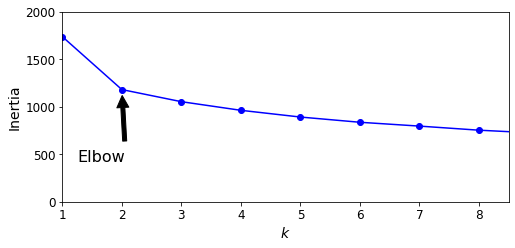

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.15, 0.35),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 2000])
plt.show()

### Second evaluation 

In [0]:
# Please comment your code

## 2.2 ICMLA Dataset

### Train K-means clustering

In [0]:
# Please comment your code

### First evaluation

In [0]:
# Please comment your code

### Second evaluation 

In [0]:
# Please comment your code



---


# 3. Hierachical Clustering

## 3.1 Travel Review Dataset

In [0]:
# import hierarchical clustering packages
from sklearn.cluster import AgglomerativeClustering

# import DBSCAN packages
from sklearn.cluster import DBSCAN

# import evaluation packages
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# set parameters
# using gridsearch methodology to handle our problems
parameters_agglo = {
    'n_clusters': [2,3,4,5,6,7,8,9,10],
    'linkage': ['single', 'average', 'complete'],
    'affinity': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
}

parameters_dbscan = {
    'eps': [0.001, 0.01, 0.1, 0.5, 1, 5],
    'min_samples': [3, 5, 8, 10],
    'metric': ['euclidean', 'manhattan']
}


In [125]:
# initiate our new-written gridsearch class using silhouette_score
gridsearch_model = GridSearch(
    'DBSCAN', 
    parameters_dbscan,
    'silhouette_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

'Grid Search Completed. Plase use get_results() to get best param combination.'

In [126]:
gridsearch_model.get_best_param()

{'eps': 0.001,
 'metric': 'euclidean',
 'min_samples': 3,
 'score': 0.27931282832051946,
 'score_type': 'silhouette_score'}

In [122]:
gridsearch_model.get_results()[:3]

[{'eps': 0.01,
  'metric': 'euclidean',
  'min_samples': 3,
  'score': 0.27931282832051946,
  'score_type': 'silhouette_score'},
 {'eps': 0.01,
  'metric': 'euclidean',
  'min_samples': 5,
  'score': 0.27931282832051946,
  'score_type': 'silhouette_score'},
 {'eps': 0.01,
  'metric': 'euclidean',
  'min_samples': 8,
  'score': 0.27931282832051946,
  'score_type': 'silhouette_score'}]

Silhouette Score

In [112]:
# initiate our new-written gridsearch class using silhouette_score
gridsearch_model = GridSearch(
    'AgglomerativeClustering', 
    parameters_agglo,
    'silhouette_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

'Grid Search Completed. Plase use get_results() to get best param combination.'

In [103]:
# get the best param combination
gridsearch_model.get_best_param()

{'affinity': 'cosine',
 'linkage': 'average',
 'n_clusters': 2,
 'score': 0.5775644930103881,
 'score_type': 'silhouette_score'}

In [93]:
# get the best five param combinations
gridsearch_model.get_results()[:5]

[{'affinity': 'cosine',
  'linkage': 'average',
  'n_clusters': 2,
  'score': 0.5775644930103881,
  'score_type': 'silhouette_score'},
 {'affinity': 'cosine',
  'linkage': 'single',
  'n_clusters': 2,
  'score': 0.5752171853778129,
  'score_type': 'silhouette_score'},
 {'affinity': 'manhattan',
  'linkage': 'average',
  'n_clusters': 2,
  'score': 0.4243376453558286,
  'score_type': 'silhouette_score'},
 {'affinity': 'l1',
  'linkage': 'average',
  'n_clusters': 2,
  'score': 0.4243376453558286,
  'score_type': 'silhouette_score'},
 {'affinity': 'euclidean',
  'linkage': 'single',
  'n_clusters': 2,
  'score': 0.41066869525048516,
  'score_type': 'silhouette_score'}]

Calinski-harabasz Score

In [113]:
# initiate our new-written gridsearch class using Calinski-harabasz Score
gridsearch_model = GridSearch(
    'AgglomerativeClustering', 
    parameters_agglo,
    'calinski_harabasz_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

'Grid Search Completed. Plase use get_results() to get best param combination.'

In [85]:
gridsearch_model.get_best_param()

{'affinity': 'euclidean',
 'linkage': 'complete',
 'n_clusters': 2,
 'score': 372.0011509667208,
 'score_type': 'calinski_harabasz_score'}

In [88]:
gridsearch_model.get_results()[:5]

[{'affinity': 'euclidean',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 372.0011509667208,
  'score_type': 'calinski_harabasz_score'},
 {'affinity': 'l2',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 372.0011509667208,
  'score_type': 'calinski_harabasz_score'},
 {'affinity': 'manhattan',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 136.82030431288362,
  'score_type': 'calinski_harabasz_score'},
 {'affinity': 'l1',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 136.82030431288362,
  'score_type': 'calinski_harabasz_score'},
 {'affinity': 'cosine',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 93.24316302799272,
  'score_type': 'calinski_harabasz_score'}]

Davies-Bouldin Score

In [114]:
# initiate our new-written gridsearch class using Davies-Bouldin Score
gridsearch_model = GridSearch(
    'AgglomerativeClustering', 
    parameters_agglo,
    'davies_bouldin_score')

# fit with Travel Advisor dataset
gridsearch_model.fit(TA_data)

'Grid Search Completed. Plase use get_results() to get best param combination.'

In [95]:
gridsearch_model.get_best_param()

{'affinity': 'manhattan',
 'linkage': 'complete',
 'n_clusters': 2,
 'score': 2.2954166608459006,
 'score_type': 'davies_bouldin_score'}

In [97]:
gridsearch_model.get_results()[:3]

[{'affinity': 'manhattan',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 2.2954166608459006,
  'score_type': 'davies_bouldin_score'},
 {'affinity': 'l1',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 2.2954166608459006,
  'score_type': 'davies_bouldin_score'},
 {'affinity': 'cosine',
  'linkage': 'complete',
  'n_clusters': 2,
  'score': 1.9087391285534911,
  'score_type': 'davies_bouldin_score'}]

What if we use demension reduction?

## 3.2 ICMLA Dataset

### Train Hierarchical clustering 

In [0]:
# Please comment your code

### First evaluation

In [0]:
# Please comment your code

### Second evalaution 

In [0]:
# Please comment your code



---


# 4. DBSCAN Clustering

## 4.1 Travel Review Dataset

### Train DBSCAN clustering 

In [0]:
# Please comment your code

### First evaluation

In [0]:
# Please comment your code

### Second evaluation 

In [0]:
# Please comment your code

## 4.2 ICMLA Dataset

### Train DBSCAN clustering 

In [0]:
# Please comment your code

### First evaluation 

In [0]:
# Please comment your code

### Second evaluation 

In [0]:
# Please comment your code